# **Iris predict**

In [4]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [26]:
# Main function 
def predictIris(path, save = False):
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)
    
   
# Show image    
def show_image(image_array):
    plt.figure(figsize=(4, 4))
    plt.imshow(image_array)
    plt.axis("off") 
    plt.show()
    # pass
        
# Load image
def load_img(path):
    image = Image.open(path)
    image_array = np.array(image)
    print("############# ORIGINAL EYE IMAGE #############")
    show_image(image_array)
    return image_array
    
# Convert to grayscale
def convert_to_grayscale(image_array):
    gray_image = np.zeros((image_array.shape[0], image_array.shape[1]), dtype=np.uint8)
    gray_image = np.mean(image_array, axis=2)
    gray_image = np.array(gray_image, dtype=np.uint8)
    print("############# GRAY IMAGE #############")
    # show_image(np.dstack((gray_image, gray_image, gray_image)))
    return gray_image

# Binarize with threshold
def binarize_image(image_array, X):
    P = np.mean(image_array)
    threshold = P / X
    binary_image = np.zeros_like(image_array)
    binary_image[image_array > threshold] = 255
    show_image(np.dstack((binary_image, binary_image, binary_image)))
    return binary_image

# Clean pupil image
def clean_pupil(binary_image):
    kernel = np.array([[1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],], dtype=np.uint8)
    kernel_small = np.ones((3, 3), np.uint8)   

    clean_image = binary_image.copy()
    
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel)
    clean_image = cv2.erode(clean_image, kernel, iterations=2)
    clean_image = cv2.dilate(clean_image, kernel_small, iterations=2)
    clean_image = cv2.medianBlur(clean_image, 5)
 
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)
    return find_pupil(horizontal_projection, vertical_projection)

# Clean iris image
def clean_iris(binary_image):
    kernel_large = np.ones((10, 10), np.uint8)   
    kernel_medium = np.ones((5, 5), np.uint8)  
    kernel_small = np.ones((3, 3), np.uint8)  
    kernel_circle_small = np.array([[0, 1, 0],
                                 [1, 1, 1],
                                 [0, 1, 0]], dtype=np.uint8)
    clean_image = binary_image.copy() 

    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=1)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=5)
    clean_image = cv2.dilate(clean_image, kernel_medium, iterations=5)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.dilate(clean_image, kernel_large, iterations=1)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_CLOSE, kernel_large)
    clean_image = cv2.erode(clean_image, kernel_small, iterations=10)
    clean_image = cv2.blur(clean_image, (5, 5), 0)
    clean_image = keep_largest_object(clean_image)
    clean_image = cv2.morphologyEx(clean_image, cv2.MORPH_OPEN, kernel_large)
    clean_image = cv2.GaussianBlur(clean_image, (9, 9), 0)
    horizontal_projection, vertical_projection = show_projections(clean_image, binary_image)   
    return find_iris(horizontal_projection, vertical_projection) 

def keep_largest_object(binary_image):
    # Odwracamy kolory: obiekt (0) -> (255), tło (255) -> (0)
    inverted_image = cv2.bitwise_not(binary_image)

    # Znajdujemy składowe połączone
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(inverted_image, connectivity=8)

    if num_labels == 1:
        # Nie znaleziono żadnych obiektów
        return binary_image
    
    # Szukamy największego obiektu (pomijamy indeks 0, bo to tło)
    largest_label = 1 + np.argmax(stats[1:, 4])

    # Tworzymy nowy obraz binarny, gdzie zostaje tylko największy obiekt
    largest_object = np.zeros_like(binary_image, dtype=np.uint8)
    largest_object[labels == largest_label] = 255  # Ustawiamy największy obiekt na biały

    # Odwracamy kolory z powrotem: obiekt (255) -> (0), tło (0) -> (255)
    return cv2.bitwise_not(largest_object)

# Show projections
def show_projections(clean_image, binary_image):
    horizontal_projection = np.sum(clean_image, axis=1)  
    vertical_projection = np.sum(clean_image, axis=0)   
    height, width = clean_image.shape
    fig, axs = plt.subplots(2, 2, figsize=(10, 6))
    axs[0, 0].imshow(np.dstack((clean_image, clean_image, clean_image)))
    axs[0, 0].set_title("Binary Image after Morphology")
    axs[0, 0].axis("off")
    axs[1, 1].axis("off")
    rect = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[0, 0].add_patch(rect)
    axs[0, 1].plot(horizontal_projection, range(height), color='blue', linewidth=2)
    axs[0, 1].set_title("Horizontal Projection")
    axs[0, 1].set_ylim(height, 0)  
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)
    axs[1, 0].plot(range(width), vertical_projection, color='red', linewidth=2)
    axs[1, 0].set_title("Vertical Projection")
    axs[1, 0].set_xlim(0, width)  
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)
    axs[1, 1].imshow(np.dstack((binary_image, binary_image, binary_image)))
    axs[1, 1].set_title("Binary Image")
    rect2 = patches.Rectangle((0, 0), width, height, linewidth=3, edgecolor='black', facecolor='none')
    axs[1, 1].add_patch(rect2)
    plt.tight_layout()
    plt.show()
    return horizontal_projection, vertical_projection

# Find pupil
def find_pupil(horizontal_projection, vertical_projection):
    y_pupil = int(np.median(np.where(horizontal_projection == np.min(horizontal_projection))[0]))
    x_pupil = int(np.median(np.where(vertical_projection == np.min(vertical_projection))[0]))

    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))
    
    pupil_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.3)[0]
    pupil_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.3)[0]
    if len(pupil_edges_y) > 1:
        r_pupil_y = (pupil_edges_y[-1] - pupil_edges_y[0]) // 2
    else:
        r_pupil_y = 0
    if len(pupil_edges_x) > 1:
        r_pupil_x = (pupil_edges_x[-1] - pupil_edges_x[0]) // 2
    else:
        r_pupil_x = 0 
    r_pupil = (r_pupil_x + r_pupil_y) // 2 # CZY TU LEPIEJ BRAĆ ŚREDNIĄ CZY JAKIŚ MAKS CZY COŚ INNEGO?
    return (x_pupil, y_pupil, r_pupil)

# Find iris
def find_iris(horizontal_projection, vertical_projection):
    horizontal_diff = np.abs(np.diff(np.array(horizontal_projection, dtype=np.int64)))
    vertical_diff = np.abs(np.diff(np.array(vertical_projection, dtype=np.int64)))

    iris_edges_y = np.where(horizontal_diff > np.max(horizontal_diff) * 0.4)[0]
    iris_edges_x = np.where(vertical_diff > np.max(vertical_diff) * 0.4)[0]

    if len(iris_edges_y) > 1:
        r_iris_y = (iris_edges_y[-1] - iris_edges_y[0]) // 2
    else:
        r_iris_y = 0

    if len(iris_edges_x) > 1:
        r_iris_x = (iris_edges_x[-1] - iris_edges_x[0]) // 2
    else:
        r_iris_x = 0 

    r_iris = (3 * r_iris_x + r_iris_y) // 4

    return r_iris

# Draw found iris and pupil
def draw_circle(image_array, x, y, r):
    image_with_circle = image_array.copy()
    image_with_circle = cv2.circle(image_with_circle, (x, y), r, (255, 0, 0), 1)
    return image_with_circle

def unwrap_iris(image, x_pupil, y_pupil, r_pupil, r_iris, output_shape=(64, 360)):
    """
    Rozwija wykrytą tęczówkę do prostokątnej postaci.
    
    :param image: Obraz wejściowy (oryginalny, grayscale lub binarny)
    :param x_pupil: Współrzędna x środka źrenicy
    :param y_pupil: Współrzędna y środka źrenicy
    :param r_pupil: Promień źrenicy
    :param r_iris: Promień tęczówki
    :param output_shape: (wysokość, szerokość) wynikowego prostokątnego obrazu
    :return: Rozwinięty obraz tęczówki
    """
    height, width = output_shape
    theta = np.linspace(0, 2 * np.pi, width)  # 360 stopni podzielone na kolumny
    r = np.linspace(r_pupil, r_iris, height)  # Promienie od źrenicy do tęczówki
    
    # Tworzenie siatki współrzędnych biegunowych
    theta_grid, r_grid = np.meshgrid(theta, r)
    
    # Zamiana na współrzędne kartezjańskie
    x_grid = (x_pupil + r_grid * np.cos(theta_grid)).astype(int)
    y_grid = (y_pupil + r_grid * np.sin(theta_grid)).astype(int)
    
    # Usunięcie punktów poza obrazem
    x_grid = np.clip(x_grid, 0, image.shape[1] - 1)
    y_grid = np.clip(y_grid, 0, image.shape[0] - 1)
    
    # Tworzenie rozwiniętego obrazu
    unwrapped_iris = image[y_grid, x_grid]
    
    return unwrapped_iris


# Funkcja do aplikacji transformaty falkowej Gabora na danym fragmencie obrazu
def apply_gabor_transform(image, f, ksize=21, theta=0, lambd=10.0, gamma=0.5):
    """
    Zastosuj filtr Gabor do danego obrazu, obliczając sigma wg. wzoru:
    sigma = 0.5 * π * f
    """
    # Obliczenie sigma zgodnie z właściwym wzorem
    sigma = 0.5 * np.pi * f

    # Filtr Gabor z fazą 0 (część rzeczywista)
    psi = 0
    kernel_real = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

    # Filtr Gabor z fazą π/2 (część urojona)
    psi = np.pi / 2
    kernel_imag = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)

    # Konwolucja obrazu z jądrami filtru
    real_response = cv2.filter2D(image, cv2.CV_32F, kernel_real)
    imag_response = cv2.filter2D(image, cv2.CV_32F, kernel_imag)

    return real_response, imag_response

# Funkcja dzieląca rozwinięty obraz tęczówki na 8 pasów radialnych i wyznaczająca kod tęczówki
def generate_iris_code(unwrapped_iris, f, n_bands=8, margin=0.1):
    """
    Dzieli rozwinięty obraz tęczówki na n pasów wzdłuż osi radialnej, usuwa marginesy (aby nie brać w analizę obszarów z rzęsami/powiekami),
    a następnie dla każdego pasa wyznacza binarny kod tęczówki przy użyciu transformaty Gabor.
    
    Parametry:
      unwrapped_iris - rozwinięty obraz tęczówki (2D, typowo wynik unwrap_iris)
      n_bands        - liczba pasów radialnych (domyślnie 8)
      margin         - ułamek wysokości pasa, który zostanie odcięty z góry i dołu (np. 0.1 oznacza 10% z każdej strony)
    
    Zwraca:
      iris_code - lista kodów dla poszczególnych pasów. Każdy element listy to krotka (code_real, code_imag),
                  gdzie code_real i code_imag są binarnymi tablicami uzyskanymi przez progowanie wyników filtru Gabor.
    """
    height, width, _ = unwrapped_iris.shape
    band_height = height // n_bands
    iris_code = []  # Lista na kody dla kolejnych pasów radialnych
    
    for i in range(n_bands):
        # Wyodrębnienie pasu – wiersze odpowiadające danemu fragmentowi tęczówki
        band = unwrapped_iris[i * band_height:(i + 1) * band_height, :]
        # Obliczamy liczbę pikseli do odcięcia z góry i dołu pasa
        margin_pixels = int(band.shape[0] * margin)
        # Wycięcie centralnej części pasa
        band_central = band[margin_pixels:band.shape[0] - margin_pixels, :]
        
        # Zastosowanie transformaty Gabora
        real_response, imag_response = apply_gabor_transform(band_central, f)
        
        # Progowanie odpowiedzi – tworzymy kod tęczówki:
        # Jeśli wartość >= 0, to bit przyjmujemy jako 1, w przeciwnym razie 0.
        code_real = (real_response >= 0).astype(np.uint8)
        code_imag = (imag_response >= 0).astype(np.uint8)
        
        iris_code.append((code_real, code_imag))
    
    return iris_code

# Funkcja pomocnicza do wizualizacji wyników kodowania (opcjonalna)
def show_iris_code(iris_code):
    """
    Wizualizacja kodu tęczówki – dla uproszczenia łączymy bitowe mapy dla części rzeczywistej i urojonej.
    W powstałym obrazie wartość 0 (czarne piksele) oznacza 0, a 255 (białe) – 1.
    """
    combined_codes = []
    for band_idx, (code_real, code_imag) in enumerate(iris_code):
        # Można np. połączyć dwie mapy kodu (np. sumując dwukrotność bitu z rzeczywistej i bit z urojonej,
        # dzięki czemu otrzymamy wartości 0, 1, 2, 3 – dla wizualizacji)
        combined = code_real * 2 + code_imag
        combined_codes.append(combined)
    
    # Połączone pasy jeden pod drugim tworzą „obraz” kodu tęczówki
    iris_code_img = np.vstack(combined_codes)
    
    plt.figure(figsize=(8, 4))
    plt.imshow(iris_code_img, cmap='gray')
    plt.title("Iris Code")
    plt.axis('off')
    plt.show()

# Przykładowe wykorzystanie – integracja z istniejącym pipeline
def predictIris_with_daugman(path, f, save=False):
    """
    Rozszerzona funkcja przetwarzania zdjęcia tęczówki,
    która dodatkowo oblicza kod tęczówki metodą Daugmana.
    """
    # Załaduj obraz i uzyskaj rozwiniętą tęczówkę (oraz wykryte koła dla źrenicy i tęczówki)
    image_array = load_img(path)
    gray_image = convert_to_grayscale(image_array)
    
    print("############# BINARY IMAGE FOR PUPIL #############")
    binary_image_pupil = binarize_image(gray_image, X=4.5)   
    print("############# BINARY IMAGE FOR IRIS #############")
    binary_image_iris = binarize_image(gray_image, X=1.6)
    
    print("############# PUPIL EXTRACTED #############")
    (x_pupil, y_pupil, r_pupil) = clean_pupil(binary_image_pupil)
    print("############# IRIS EXTRACTED #############")
    r_iris = clean_iris(binary_image_iris)
      
    image_with_pupil = draw_circle(image_array, x_pupil, y_pupil, r_pupil)
    image_with_pupil_and_iris = draw_circle(image_with_pupil, x_pupil, y_pupil, r_iris)
    
    print("############# FOUND PUPIL AND IRIS #############")
    show_image(image_with_pupil_and_iris)
    
    if save:
        import os
        save_path = os.path.join("found", f'{os.path.basename(path)}_found.bmp')
        cv2.imwrite(save_path, image_with_pupil_and_iris)
        print(f"Image saved to {save_path}")
    
    print("############# UNWRAPPED IRIS #############")    
    unwrapped_iris = unwrap_iris(image_array, x_pupil, y_pupil, r_pupil, r_iris)
    show_image(unwrapped_iris)
    
    # Generowanie kodu tęczówki przy użyciu algorytmu Daugmana
    print("############# IRIS CODE (Daugman) #############")
    iris_code = generate_iris_code(unwrapped_iris, f=f, n_bands=8, margin=0.1)
    show_iris_code(iris_code)
    
    return iris_code

## Simple example

############# ORIGINAL EYE IMAGE #############


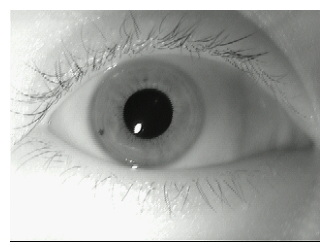

############# GRAY IMAGE #############
############# BINARY IMAGE FOR PUPIL #############


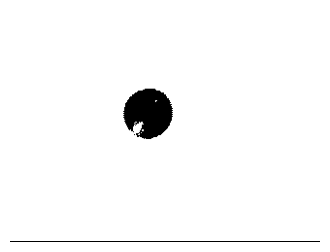

############# BINARY IMAGE FOR IRIS #############


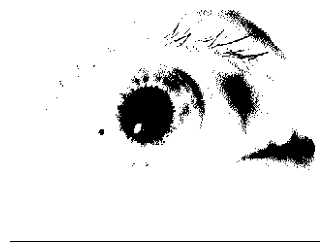

############# PUPIL EXTRACTED #############


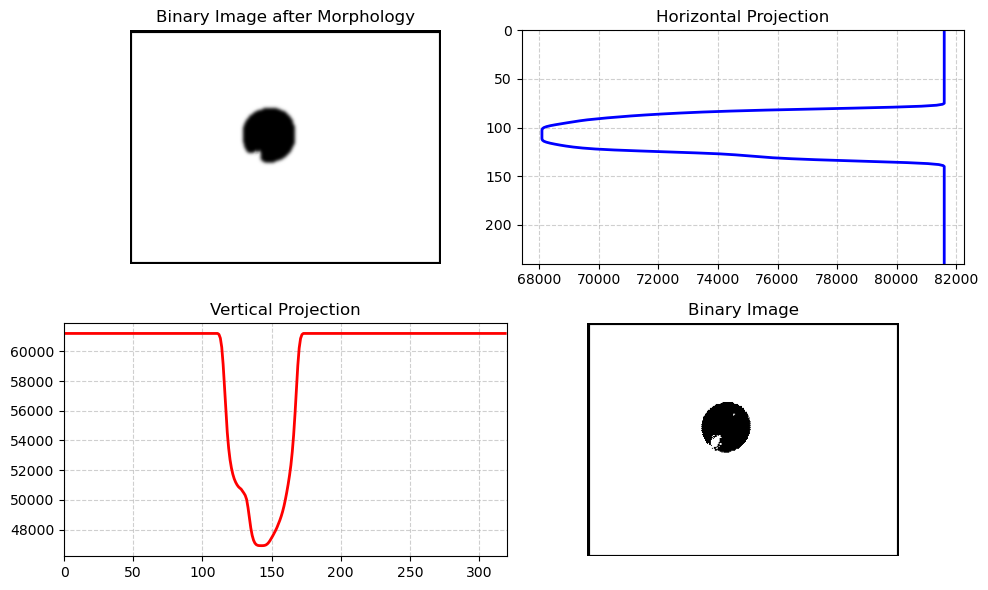

############# IRIS EXTRACTED #############


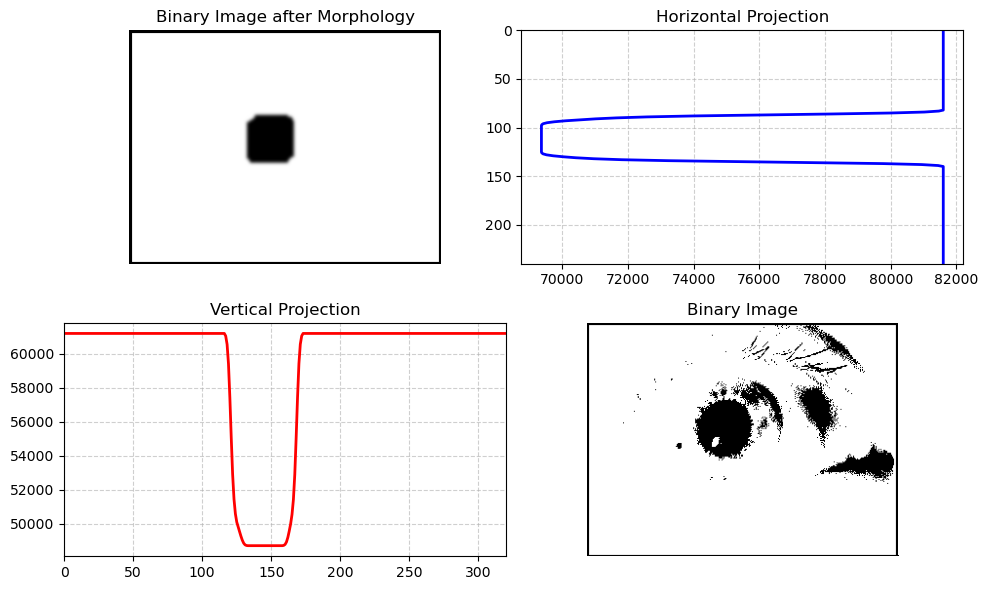

############# FOUND PUPIL AND IRIS #############


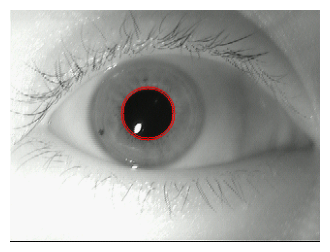

############# UNWRAPPED IRIS #############


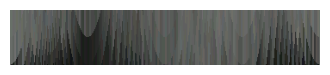

In [10]:
person_id = 30
eye = 'right'
photo_number = 5
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

predictIris(path)

In [ ]:
for file in os.listdir("data"):
    if file.endswith(".bmp"):
        file_path = os.path.join("data", file)
        print(f"Processed {file_path}")
        predictIris(file_path, save=True)


############# ORIGINAL EYE IMAGE #############


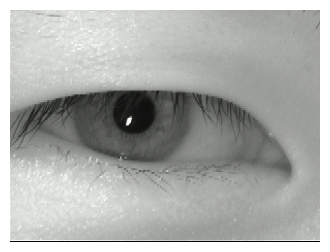

############# GRAY IMAGE #############
############# BINARY IMAGE FOR PUPIL #############


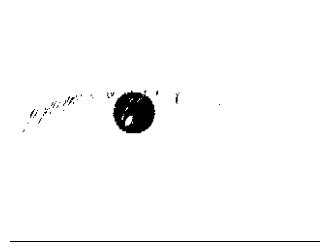

############# BINARY IMAGE FOR IRIS #############


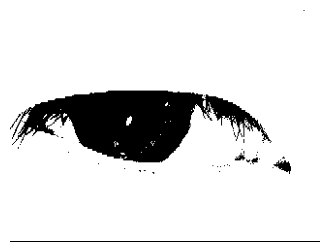

############# PUPIL EXTRACTED #############


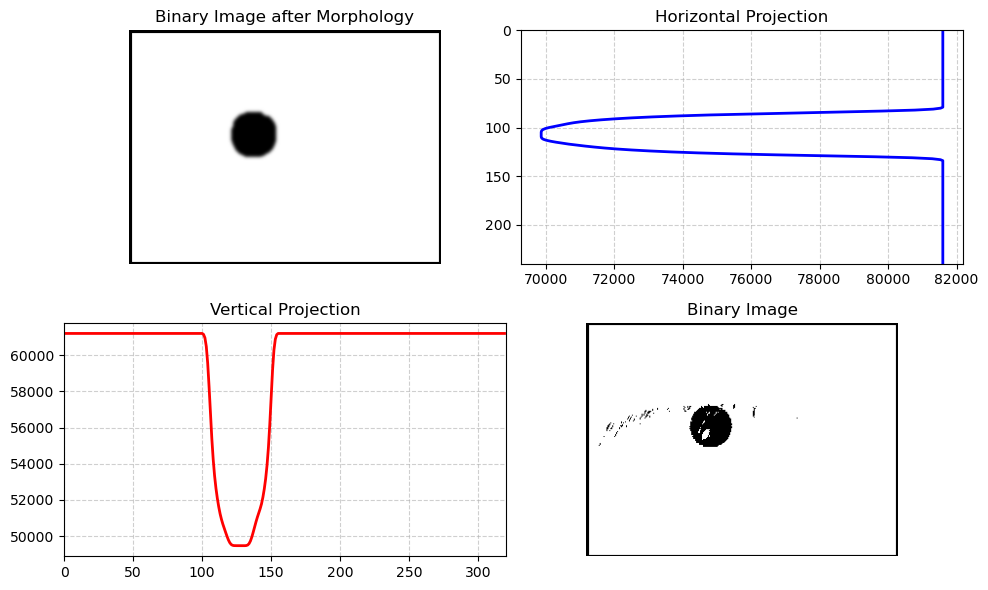

############# IRIS EXTRACTED #############


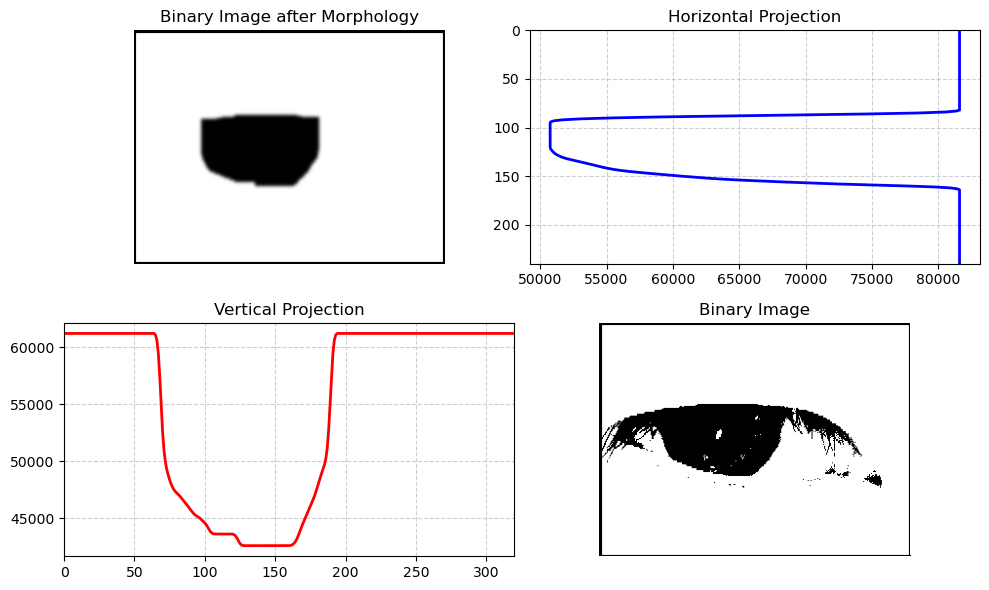

############# FOUND PUPIL AND IRIS #############


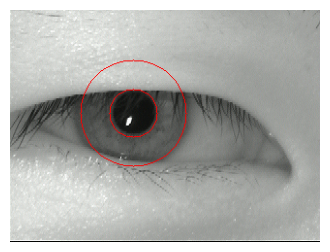

############# UNWRAPPED IRIS #############


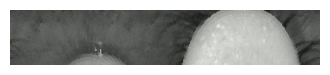

############# IRIS CODE (Daugman) #############


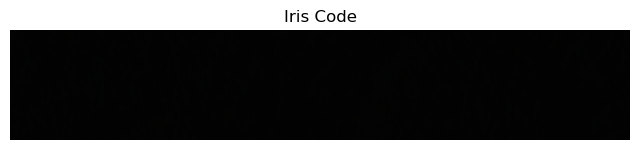

[(array([[[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
  
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
  
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
  
         ...,
  
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
  
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]],
  
         [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1],
          ...,
          [1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]]], dtype=uint8),
  array([[[1, 1, 1],
          [0, 0, 0],
          [1, 1, 1],
          ...,
          [1, 0, 1],
  

In [27]:
person_id = 15
eye = 'right'
photo_number = 5
path = os.path.join(f'data/eye_p{person_id:02d}_{eye}{photo_number}.bmp')

predictIris_with_daugman(path, 0.1)